In [113]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.transform import Rotation as R
import tqdm

In [114]:
# from pierros-dev
def expand_column(df, column_name):
    # Remove brackets and extra spaces/newlines, then split into individual values
    clean_data = df[column_name].apply(lambda x: x.replace('[', '').replace(']', '').replace('\n', ' ').strip().split())
    # Convert 'inf' to np.inf and convert values to float
    clean_data = clean_data.apply(lambda x: [np.inf if v == 'inf' else float(v) for v in x])
    
    # Create a new DataFrame with the expanded columns
    expanded_df = pd.DataFrame(clean_data.tolist(), index=df.index)
    # Rename the columns
    expanded_df.columns = [f"{column_name}_{i+1}" for i in range(expanded_df.shape[1])]
    
    return expanded_df

merged_df = pd.read_csv("../data/merged_lidar_odom_data.csv")
merged_df = pd.concat([merged_df, expand_column(merged_df, 'ranges')], axis=1)
merged_df = merged_df.drop(["ranges"], axis=1)

In [115]:
# modified from pierros-dev
def radar_data(df):
    # Replace np.inf with np.nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Select columns starting with 'ColumnX'
    columns_to_plot = df.filter(regex='^ranges_').columns

    # Convert selected columns to numeric
    df[columns_to_plot] = df[columns_to_plot].apply(pd.to_numeric, errors='coerce')

    data = []

    for row_index in range(len(df)):
        # Extract data for the specified row and columns
        data_to_plot = df.loc[row_index, columns_to_plot]

        # Check if data_to_plot is empty or all NaNs
        if data_to_plot.isnull().all():
            print(f"No valid data found for Row {row_index}. Radar plot cannot be generated.")
        else:
            data_to_plot = np.concatenate((data_to_plot.values, [data_to_plot.values[0]]))
            data.append(data_to_plot)

    # Number of variables
    num_vars = len(columns_to_plot)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop" and append the start value to the end.
    angles += angles[:1]

    return num_vars, angles, data

In [116]:
num_vars, angles, data = radar_data(merged_df)

pos_x = merged_df['position_x']
pos_y = merged_df['position_y']
pos_z = merged_df['position_z']

orient_x = merged_df['orientation_x']
orient_y = merged_df['orientation_y']
orient_z = merged_df['orientation_z']
orient_w = merged_df['orientation_w']

def sensor_to_frame_0(index):
    # modified from lidar_preprocessing.ipynb/sensor_to_world_frame()
    r = np.array(data[index])
    theta = np.array(angles) + np.pi/2

    # converting polar coordinates to cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # retrieving rotation matrix from quaternion measurement values
    rot = R.from_quat([orient_x[index], orient_y[index], orient_z[index], orient_w[index]])
    rot_0 = R.from_quat([orient_x[0], orient_y[0], orient_z[0], orient_w[0]])

    # converting sensor frame measurements to world frame measurements

    # rotation - modified to move to frame 0
    pts_vector = np.array([x[:-1], y[:-1], np.ones((num_vars))])  # remember data has +1 element due to completing radar circle
    pts_rotated = np.linalg.inv(rot_0.as_matrix()) @ rot.as_matrix() @ pts_vector
    x, y, _ = pts_rotated

    # translation - modified to move to frame 0
    x -= (pos_y.iloc[index] - pos_y.iloc[0])
    y += (pos_x.iloc[index] - pos_x.iloc[0])

    return x, y

In [117]:
def transform_cloud_numpy(pose, clouda):
    """Transforms each point in a cloud given a transform.

    Args:
        pose (3, 3): the transform used on each point in the cloud.
        clouda (a numpy array of shape (3, n)): the cloud that we want to transform

    Returns:
        a numpy array of shape (3, n), where each 3D point is transformed by the pose
    """
    
    trans = pose @ clouda # (3, 3) @ (3, n) = (3, n)
    return trans

In [118]:
from sklearn.neighbors import NearestNeighbors

def assign_closest_pairs_KDTree(clouda, cloudb): # ((n, 2), (n, 2))
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(cloudb)
    dist, indices = nbrs.kneighbors(clouda, return_distance=True)
    return dist.ravel(), indices.ravel()

In [124]:
def estimate_transform(clouda, cloudb): # (n, 2), (n, 2)
    # number of dimensions
    m = clouda.shape[1]
    # find centroids
    clouda_centroid= np.mean(clouda, axis=0) # (1, 2)
    cloudb_centroid = np.mean(cloudb, axis=0) # (1, 2)

    # translate points to their centroids (centering the point clouds)
    clouda2 = clouda - clouda_centroid
    cloudb2 = cloudb - cloudb_centroid

    # rotation matrix
    H = np.dot(clouda2.T, cloudb2)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m-1,:] *= -1
    R = np.dot(Vt.T, U.T)

    # translation
    t = cloudb_centroid.T - np.dot(R,clouda_centroid.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

In [120]:
def icp(clouda, cloudb, initial_transform=np.eye(3), max_iterations=25, tolerance=1e-5):
    """Runs ICP on two clouds. Iterates until close enough or max iterations.

    Returns bTa (3, 3) object that aligns clouda with cloudb and a list of 
    intermediate transformations of clouda to cloudb for visualization purposes.

    Args:
        clouda (a numpy array of shape (n, 2)): point cloud A
        cloudb (a numpy array of shape (n, 2)): point cloud B
        initial_transform (3, 3):               the initial estimate of transform 
                                                between clouda and cloudb (step 1 of icp)
        max_iterations (int):                   maximum iterations of ICP to run before breaking

    Returns:
        gtsam.Pose3, [series of clouds formatted for visualization]
    """
    icp_series = []
    clouda_h = np.vstack((np.copy(clouda.T), np.full((1, len(clouda)), 1))) # (3, n)

    prev_transform = initial_transform # (3, 3)
    prev_err = 0

    transformed_cloud_a = transform_cloud_numpy(initial_transform, clouda_h) # t_c_n((3, 3), (3, n)) = (3, n)
    icp_series.append([transformed_cloud_a[:-1, :], cloudb]) # [(2, n), (n, 2)]

    for i in range(max_iterations):
        dist, indices = assign_closest_pairs_KDTree(transformed_cloud_a[:-1, :].T, cloudb) # a_c_p_k((n, 2), (n, 2))
        prev_transform, _, _ = estimate_transform(transformed_cloud_a[:-1, :].T, cloudb[indices, :]) # e_t((n, 2), (n, 2))
        
        transformed_cloud_a = transform_cloud_numpy(prev_transform, transformed_cloud_a)
        icp_series.append([transformed_cloud_a[:-1, :], cloudb])
    
        mean_err = np.mean(dist)
        if np.abs(mean_err - prev_err) < tolerance:
            break
        prev_err = mean_err
        # print(i)

    bTa = prev_transform

    return bTa, dist, transformed_cloud_a[:-1, :].T

In [121]:
num_vars, angles, data = radar_data(merged_df)

r0 = np.array(data[0])
theta0 = np.array(angles) + np.pi/2

x0 = r0 * np.cos(theta0)
y0 = r0 * np.sin(theta0)

xy0_rot = R.from_quat([orient_x[0], orient_y[0], orient_z[0], orient_w[0]]).as_matrix()

# replace nan entries with np.inf
x0_nan = (np.where(np.isnan(x0))[0])
y0_nan = (np.where(np.isnan(y0))[0])

x0[x0_nan] = 100
y0[y0_nan] = 100
xy0 = np.vstack((x0[:-1], y0[:-1])).T #  (n, 2)

x0

array([ 1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02, -3.73936264e-01,
       -4.22125487e-01, -4.73974716e-01, -3.49092294e-01, -3.75943198e-01,
       -4.04152051e-01, -4.35792189e-01, -4.69174760e-01, -5.05646279e-01,
       -5.39337850e-01, -5.82197057e-01,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02, -3.53527474e-01, -3.52549345e-01, -3.60239589e-01,
       -3.73676804e-01, -3.91912763e-01, -4.00638815e-01, -4.19531558e-01,
       -4.21449580e-01, -4.47089997e-01, -4.58708525e-01, -4.76267399e-01,
       -4.82700225e-01, -5.15061051e-01, -5.29953529e-01, -5.43086920e-01,
       -5.93472251e-01, -1.47779085e+00, -1.50026211e+00, -1.52848563e+00,
       -1.58060805e+00, -1.64006721e+00,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
        1.00000000e+02,  

In [142]:
def run_icp(index):
    global x0, y0

    r = np.array(data[index])
    theta = np.array(angles) + np.pi/2

    x = r * np.cos(theta)
    y = r * np.sin(theta)

    # replace nan entries with np.inf
    x_nan = (np.where(np.isnan(x))[0])
    y_nan = (np.where(np.isnan(y))[0])

    x[x_nan] = 100
    y[y_nan] = 100
    xy = np.vstack((x[:-1], y[:-1])).T # (n, 2)

    rot = R.from_quat([orient_x[index], orient_y[index], orient_z[index], orient_w[index]])
    rot = rot.as_matrix() # (3, 3)
    init_rot = np.linalg.inv(xy0_rot) @ rot

    bTa, dist, xy_trans = icp(xy, xy0, init_rot, 40) # icp((n, 2), (n, 2), (3, 3))
    print("RMSE error for ICP:", np.sqrt(np.mean(np.square(dist))))

    rot = R.from_quat([orient_x[index], orient_y[index], orient_z[index], orient_w[index]])
    rot = rot.as_matrix() # (3, 3)

    x0_inf = (np.where(np.absolute(x0) < 10)[0])
    x0 = x0[x0_inf]
    y0 = y0[x0_inf]

    xy_trans_inf = (np.where(np.abs(xy_trans[:, 0]) < 10)[0])
    xy_trans_clean = xy_trans[xy_trans_inf]

    # plotting final map
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x0, y0, color='red', s=15, label="original point cloud at timeframe 0")
    ax.scatter(xy_trans_clean[:, 0], xy_trans_clean[:, 1], color='brown', s=15, label="point cloud at timeframe 150 (ICP)")

    x, y = sensor_to_frame_0(index)
    ax.scatter(x, y, color='yellow', s=15, label="point cloud at timeframe 150 (encoders)")

    x_nan = (np.where(np.isnan(x))[0])
    y_nan = (np.where(np.isnan(y))[0])

    x[x_nan] = 100
    y[y_nan] = 100
    xy = np.vstack((x, y)).T # (n, 2)

    dist, _ = assign_closest_pairs_KDTree(xy, xy0)
    print("RMSE error for encoders:", np.sqrt(np.mean(np.square(dist))))
    
    plt.axhline(0, color='gray', lw=0.5)
    plt.axvline(0, color='gray', lw=0.5)
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title(f'Cartesian Scatter')
    plt.show()

RMSE error for ICP: 0.23269219250269607
RMSE error for encoders: 0.22788055921767322


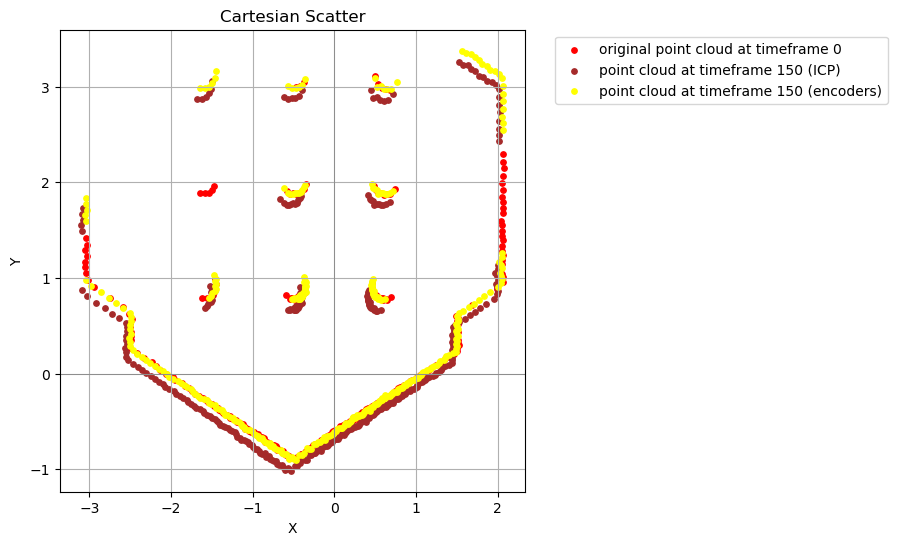

In [143]:
run_icp(150)